In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime
import time

class MetricsAnalyzer:
    def __init__(self, result_files: List[str]):
        
        self.model_order = ['GPT-4', 'Claude-3', 'Llama-3.2', 'Qwen-2.5', 'Gemma-2']
        self.discipline_order = ['Mathematics', 'Physics', 'Biology', 
                               'Chemistry', 'Earth Science', 'Computer Science']
        self.results = self._load_and_combine_results(result_files)

        self.experiment_metrics = {
            1: ['Error Detected', 'Error Identification Accuracy'],
            2: ['Error Admitted', 'Correction Quality'],
            3: ['Context Consistency']
        }
    
    def _load_and_combine_results(self, result_files: List[str]) -> pd.DataFrame:

        dfs = []
        for file in result_files:
            df = pd.read_csv(file)

            if 'Gemma' in file:
                disciplines = ['Mathematics'] * 100 + ['Physics'] * 100 + ['Biology'] * 100 + \
                            ['Chemistry'] * 100 + ['Earth Science'] * 100 + ['Computer Science'] * 100 + \
                            ['Mathematics'] * 99 + ['Physics'] * 100 + ['Biology'] * 100 + \
                            ['Chemistry'] * 100 + ['Earth Science'] * 100 + ['Computer Science'] * 100 + \
                            ['Mathematics'] * 100 + ['Physics'] * 100 + ['Biology'] * 100 + \
                            ['Chemistry'] * 100 + ['Earth Science'] * 100 + ['Computer Science'] * 100
            else:
                disciplines = ['Mathematics'] * 100 + ['Physics'] * 100 + ['Biology'] * 100 + \
                            ['Chemistry'] * 100 + ['Earth Science'] * 100 + ['Computer Science'] * 100 + \
                            ['Mathematics'] * 100 + ['Physics'] * 100 + ['Biology'] * 100 + \
                            ['Chemistry'] * 100 + ['Earth Science'] * 100 + ['Computer Science'] * 100 + \
                            ['Mathematics'] * 100 + ['Physics'] * 100 + ['Biology'] * 100 + \
                            ['Chemistry'] * 100 + ['Earth Science'] * 100 + ['Computer Science'] * 100
            
            df['Discipline'] = disciplines
            dfs.append(df)
        
        combined_df = pd.concat(dfs, ignore_index=True)

        combined_df['Model'] = pd.Categorical(combined_df['Model'], 
                                            categories=self.model_order, 
                                            ordered=True)
        combined_df['Discipline'] = pd.Categorical(combined_df['Discipline'], 
                                                 categories=self.discipline_order, 
                                                 ordered=True)
        return combined_df
    
    def _preprocess_data(self, series):

        if pd.api.types.is_bool_dtype(series):
            return series.astype(int)
        else:
            return pd.to_numeric(series, errors='coerce')
    
    def _get_exp2_relevant_data(self, exp_data: pd.DataFrame) -> pd.DataFrame:

        exp1_data = self.results[self.results['Experiment'] == 1]
        # Error Detected가 False인 케이스 찾기
        exp1_false_detections = exp1_data[
            self._preprocess_data(exp1_data['Error Detected']) == 0
        ][['Model', 'Question']].drop_duplicates()
        
        filtered_data = pd.merge(
            exp_data, 
            exp1_false_detections, 
            on=['Model', 'Question']
        )
        
        return filtered_data

    def summarize_model_experiment_metrics(self):

        summaries = []
        
        for experiment in [1, 2, 3]:
            exp_data = self.results[self.results['Experiment'] == experiment]
            

            if experiment == 2:
                exp_data = self._get_exp2_relevant_data(exp_data)
            
            metrics = self.experiment_metrics[experiment]
            for metric in metrics:
                summary = exp_data.groupby('Model', observed=True)[metric].agg([
                    'mean', 'std', 'count'
                ]).round(4)
                summary = summary.reindex(self.model_order)
                summary = summary.reset_index()
                summary['Experiment'] = experiment
                summary['Metric'] = metric
                summaries.append(summary)
        
        final_summary = pd.concat(summaries, ignore_index=True)
        final_summary.to_csv('model_experiment_metrics.csv', index=False)
        return final_summary

    def analyze_model_significance(self):

        significance_results = []
        
        for experiment in [1, 2, 3]:
            exp_data = self.results[self.results['Experiment'] == experiment]
            
            if experiment == 2:
                exp_data = self._get_exp2_relevant_data(exp_data)
            
            metrics = self.experiment_metrics[experiment]
            for metric in metrics:
                print(f"\n=== Experiment {experiment}: {metric} ===")
                print(f"Total data points: {len(exp_data)}")

                groups = []
                valid_models = []
                for model in self.model_order:
                    if model in exp_data['Model'].unique():
                        model_data = exp_data[exp_data['Model'] == model]
                        data = self._preprocess_data(model_data[metric]).dropna()
                        print(f"\n{model}:")
                        print(f"  Total rows: {len(model_data)}")
                        print(f"  Valid data after preprocessing: {len(data)}")
                        if len(data) > 0:
                            groups.append(data)
                            valid_models.append(model)
                
                if len(groups) >= 2:
                    h_stat, p_value = stats.kruskal(*groups)
                    print(f"\nKruskal-Wallis test: H={h_stat:.4f}, p={p_value:.4f}")
                    
                    if p_value < 0.05:
                        print("\nPost-hoc Mann-Whitney U tests:")
                        n_pairs = len(valid_models) * (len(valid_models) - 1) // 2
                        alpha_corrected = 0.05 / n_pairs
                        
                        for i, model1 in enumerate(valid_models):
                            for model2 in valid_models[i+1:]:
                                result = self._mann_whitney_test(
                                    exp_data, model1, model2, metric, alpha_corrected)
                                if result is not None:
                                    result.update({
                                        'Experiment': experiment,
                                        'Metric': metric
                                    })
                                    significance_results.append(result)
                else:
                    print(f"Skipping {metric}: insufficient valid data for comparison")
        
        if significance_results:
            pd.DataFrame(significance_results).to_csv('model_significance.csv', index=False)
            
    def _mann_whitney_test(self, data: pd.DataFrame, model1: str, model2: str, 
                          metric: str, alpha: float) -> Dict:
        group1 = self._preprocess_data(data[data['Model'] == model1][metric]).dropna()
        group2 = self._preprocess_data(data[data['Model'] == model2][metric]).dropna()
        
        if len(group1) > 0 and len(group2) > 0:
            stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            significant = p_val < alpha
            
            result = {
                'Model1': model1,
                'Model2': model2,
                'U_statistic': stat,
                'p_value': p_val,
                'Significant': significant,
                'Mean1': group1.mean(),
                'Mean2': group2.mean(),
                'Median1': group1.median(),
                'Median2': group2.median(),
                'N1': len(group1),
                'N2': len(group2)
            }
            
            print(f"{model1} vs {model2}: "
                  f"U={stat:.1f}, p={p_val:.4f} {'*' if significant else 'ns'} "
                  f"(n1={len(group1)}, n2={len(group2)})")
            return result
        else:
            print(f"Skipping {model1} vs {model2}: insufficient data")
            return None

    def summarize_model_discipline_metrics(self):
        summaries = []
        
        for experiment in [1, 2, 3]:
            exp_data = self.results[self.results['Experiment'] == experiment]
            
            # 실험 2인 경우 관련 데이터만 필터링
            if experiment == 2:
                exp_data = self._get_exp2_relevant_data(exp_data)
            
            metrics = self.experiment_metrics[experiment]
            for metric in metrics:
                summary = exp_data.groupby(['Model', 'Discipline'], observed=True)[metric].agg([
                    'mean', 'std', 'count'
                ]).round(4)
                summary = summary.reindex(
                    pd.MultiIndex.from_product(
                        [self.model_order, self.discipline_order],
                        names=['Model', 'Discipline']
                    )
                )
                summary = summary.reset_index()
                summary['Experiment'] = experiment
                summary['Metric'] = metric
                summaries.append(summary)
        
        final_summary = pd.concat(summaries, ignore_index=True)
        final_summary.to_csv('model_discipline_metrics.csv', index=False)
        return final_summary

    def analyze_discipline_significance(self):
        significance_results = []
        
        for experiment in [1, 2, 3]:
            exp_data = self.results[self.results['Experiment'] == experiment]
            
            if experiment == 2:
                exp_data = self._get_exp2_relevant_data(exp_data)
            
            metrics = self.experiment_metrics[experiment]
            
            for discipline in self.discipline_order:
                if discipline in exp_data['Discipline'].unique():
                    print(f"\n=== Experiment {experiment}, {discipline} ===")
                    discipline_data = exp_data[exp_data['Discipline'] == discipline]
                    
                    for metric in metrics:
                        print(f"\n{metric}:")
                        groups = []
                        valid_models = []
                        
                        for model in self.model_order:
                            if model in discipline_data['Model'].unique():
                                model_data = discipline_data[discipline_data['Model'] == model]
                                data = self._preprocess_data(model_data[metric]).dropna()
                                print(f"\n{model}:")
                                print(f"  Total rows: {len(model_data)}")
                                print(f"  Valid data after preprocessing: {len(data)}")
                                if len(data) > 0:
                                    groups.append(data)
                                    valid_models.append(model)
                        
                        if len(groups) >= 2:
                            h_stat, p_value = stats.kruskal(*groups)
                            print(f"\nKruskal-Wallis test: H={h_stat:.4f}, p={p_value:.4f}")
                            
                            if p_value < 0.05:
                                print("\nPost-hoc Mann-Whitney U tests:")
                                n_pairs = len(valid_models) * (len(valid_models) - 1) // 2
                                alpha_corrected = 0.05 / n_pairs
                                
                                for i, model1 in enumerate(valid_models):
                                    for model2 in valid_models[i+1:]:
                                        result = self._mann_whitney_test(
                                            discipline_data, model1, model2,
                                            metric, alpha_corrected)
                                        if result is not None:
                                            result.update({
                                                'Experiment': experiment,
                                                'Discipline': discipline,
                                                'Metric': metric
                                            })
                                            significance_results.append(result)
                        else:
                            print(f"Skipping {metric}: insufficient valid data for comparison")
        
        if significance_results:
            df_results = pd.DataFrame(significance_results)
            df_results['Model1'] = pd.Categorical(df_results['Model1'], 
                                                categories=self.model_order, 
                                                ordered=True)
            df_results['Model2'] = pd.Categorical(df_results['Model2'], 
                                                categories=self.model_order, 
                                                ordered=True)
            df_results['Discipline'] = pd.Categorical(df_results['Discipline'], 
                                                    categories=self.discipline_order, 
                                                    ordered=True)
            df_results = df_results.sort_values(['Experiment', 'Discipline', 'Model1', 'Model2'])
            df_results.to_csv('model_discipline_significance.csv', index=False)
    def create_visualizations(self):

        plt.ion() 

        for experiment in [1, 2, 3]:
            exp_data = self.results[self.results['Experiment'] == experiment]
            metrics = self.experiment_metrics[experiment]


            if experiment == 2:
                exp_data = self._get_exp2_relevant_data(exp_data)

            for metric in metrics:
 
                if metric not in ['Error Identification Accuracy', 'Correction Quality', 'Context Consistency']:
                    continue

                if pd.api.types.is_bool_dtype(exp_data[metric]):
                    plot_data = exp_data.copy()
                    plot_data[metric] = plot_data[metric].astype(int)
                else:
                    plot_data = exp_data.copy()

                if metric == 'Correction Quality':
                    plot_data = plot_data[plot_data[metric] <= 1]

                plt.figure(figsize=(15, 8))
                sns.boxplot(
                    data=plot_data,
                    x='Model',
                    y=metric,
                    order=self.model_order
                )
                plt.title(f'Experiment {experiment}: {metric} by Model')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(f'exp{experiment}_{metric.lower().replace(" ", "_")}_overall.png')
                plt.show()
                plt.close()

                plt.figure(figsize=(20, 10))
                sns.boxplot(
                    data=plot_data,
                    x='Model',
                    y=metric,
                    hue='Discipline',
                    order=self.model_order,
                    hue_order=self.discipline_order
                )
                plt.title(f'Experiment {experiment}: {metric} by Model and Discipline')
                plt.xticks(rotation=45)
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.savefig(f'exp{experiment}_{metric.lower().replace(" ", "_")}_by_model_discipline.png')
                plt.show()
                plt.close()


def run_analysis(result_files: List[str]):
    """분석 실행"""
    analyzer = MetricsAnalyzer(result_files)
    
    print("\nGenerating model/experiment metrics...")
    analyzer.summarize_model_experiment_metrics()
    
    print("\nAnalyzing model significance...")
    analyzer.analyze_model_significance()
    
    print("\nGenerating model/discipline metrics...")
    analyzer.summarize_model_discipline_metrics()
    
    print("\nAnalyzing discipline-specific significance...")
    analyzer.analyze_discipline_significance()
    
    print("\nCreating visualizations...")
    analyzer.create_visualizations()





Generating model/experiment metrics...

Analyzing model significance...

=== Experiment 1: Error Detected ===
Total data points: 3000

GPT-4:
  Total rows: 600
  Valid data after preprocessing: 600

Claude-3:
  Total rows: 600
  Valid data after preprocessing: 600

Llama-3.2:
  Total rows: 600
  Valid data after preprocessing: 600

Qwen-2.5:
  Total rows: 600
  Valid data after preprocessing: 600

Gemma-2:
  Total rows: 600
  Valid data after preprocessing: 600

Kruskal-Wallis test: H=102.3214, p=0.0000

Post-hoc Mann-Whitney U tests:
GPT-4 vs Claude-3: U=194700.0, p=0.0000 * (n1=600, n2=600)
GPT-4 vs Llama-3.2: U=197700.0, p=0.0000 * (n1=600, n2=600)
GPT-4 vs Qwen-2.5: U=170700.0, p=0.0228 ns (n1=600, n2=600)
GPT-4 vs Gemma-2: U=197100.0, p=0.0000 * (n1=600, n2=600)
Claude-3 vs Llama-3.2: U=183000.0, p=0.2734 ns (n1=600, n2=600)
Claude-3 vs Qwen-2.5: U=156000.0, p=0.0000 * (n1=600, n2=600)
Claude-3 vs Gemma-2: U=182400.0, p=0.3857 ns (n1=600, n2=600)
Llama-3.2 vs Qwen-2.5: U=153000.0

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


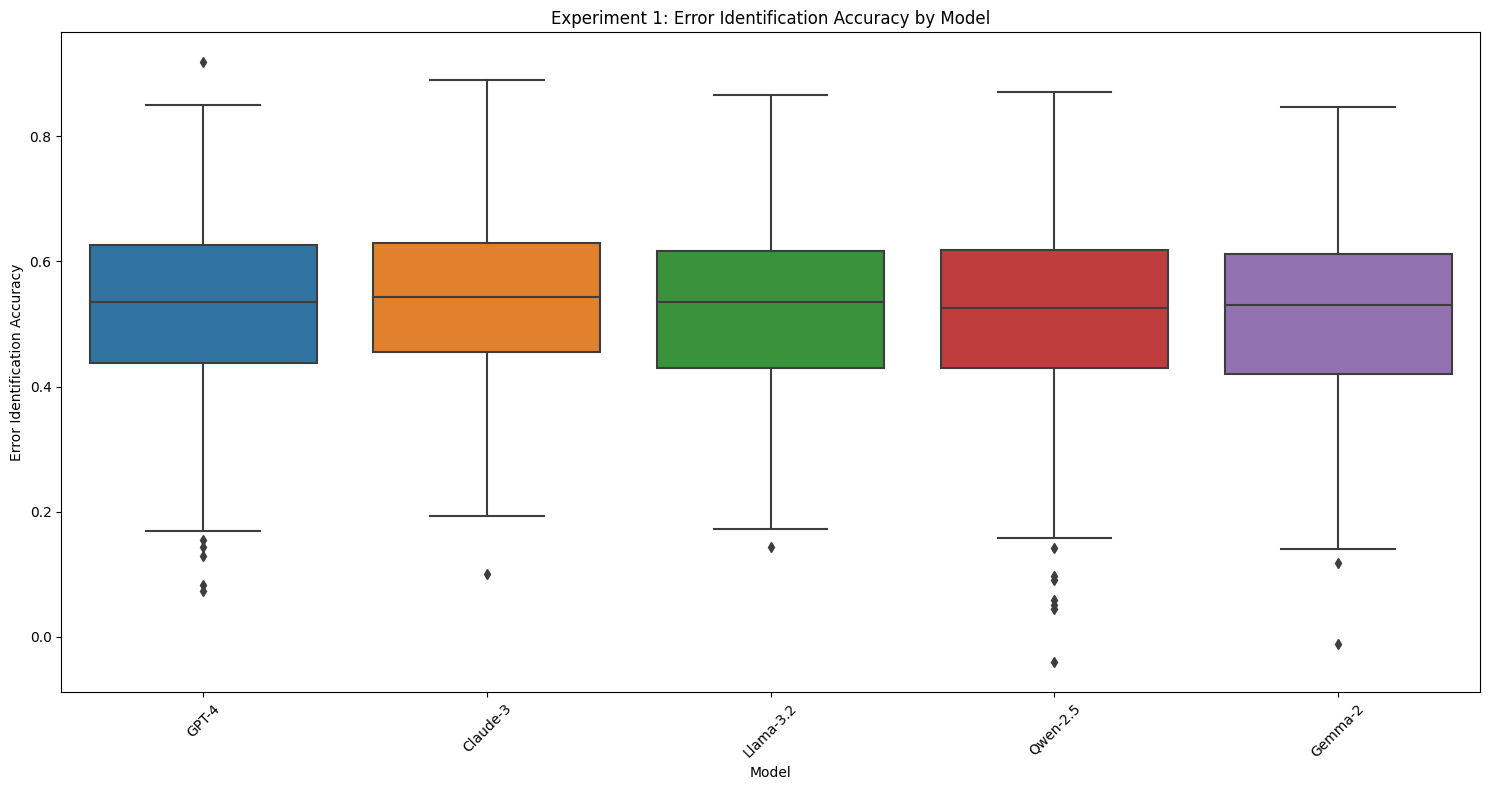

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


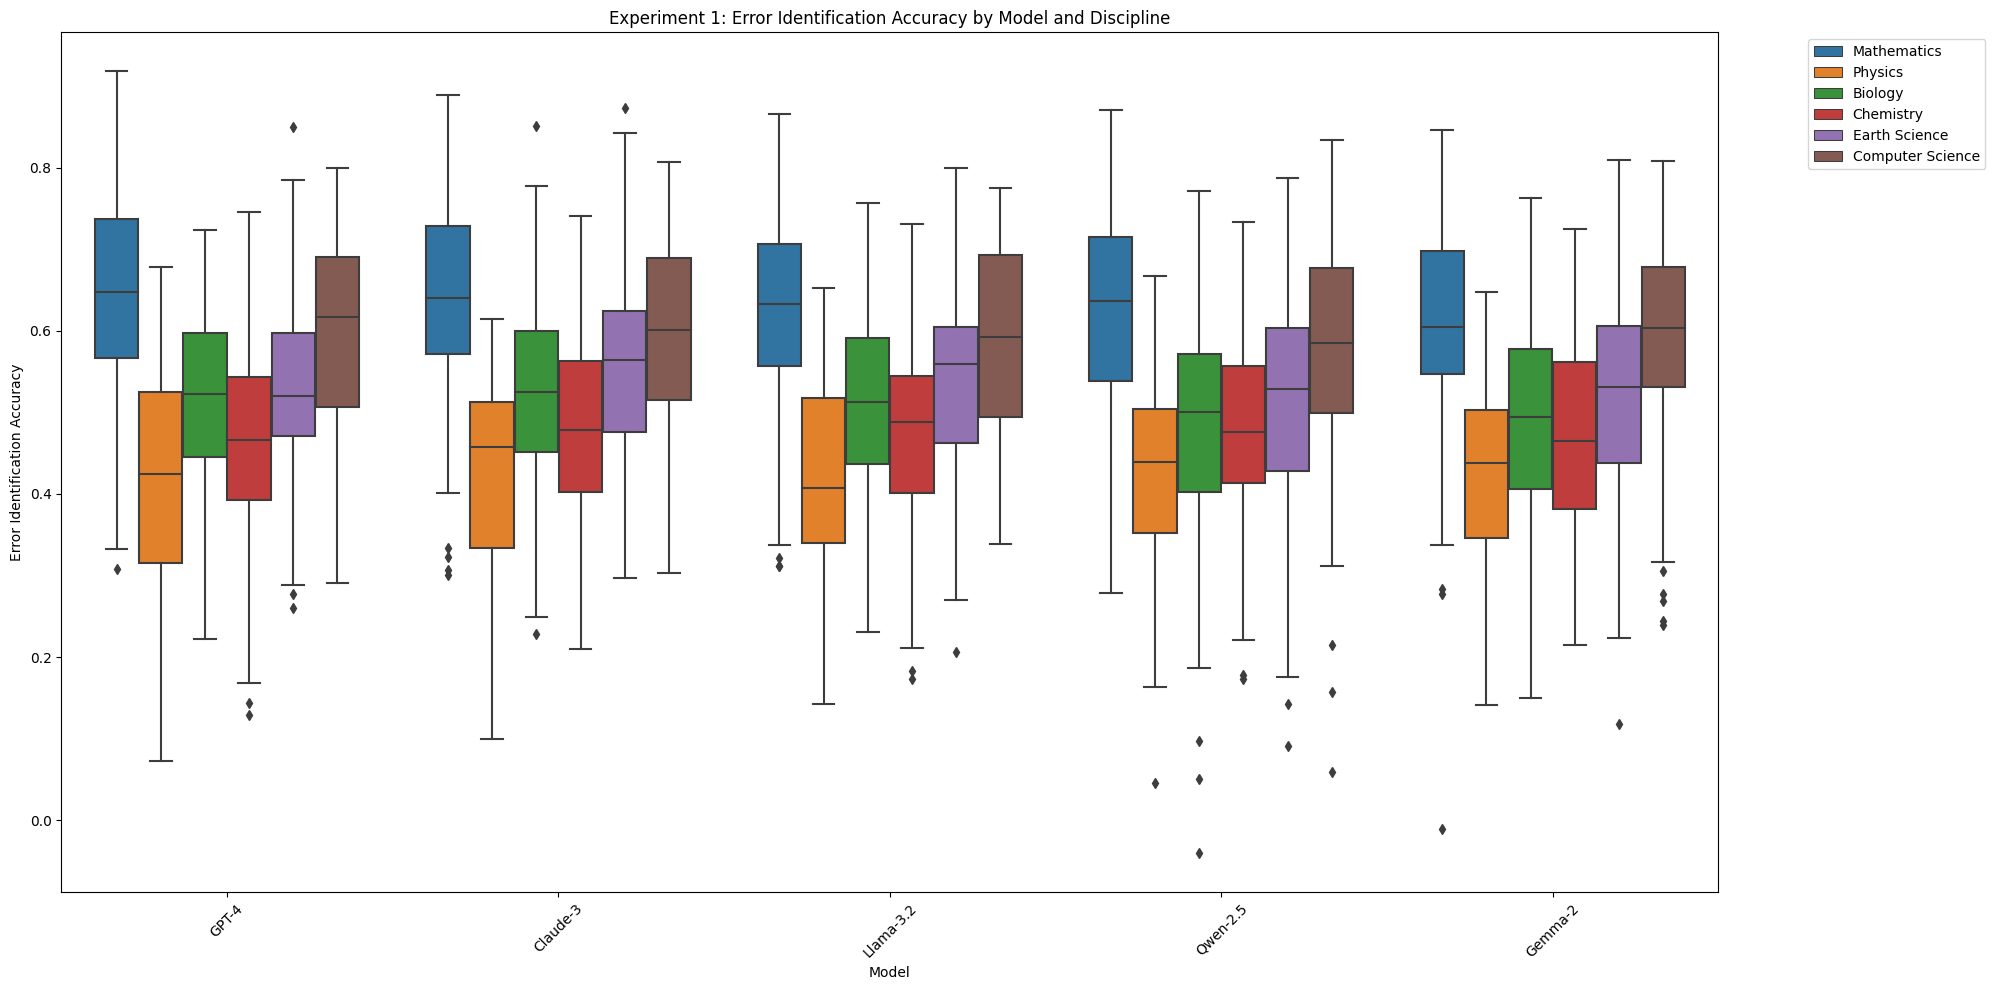

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


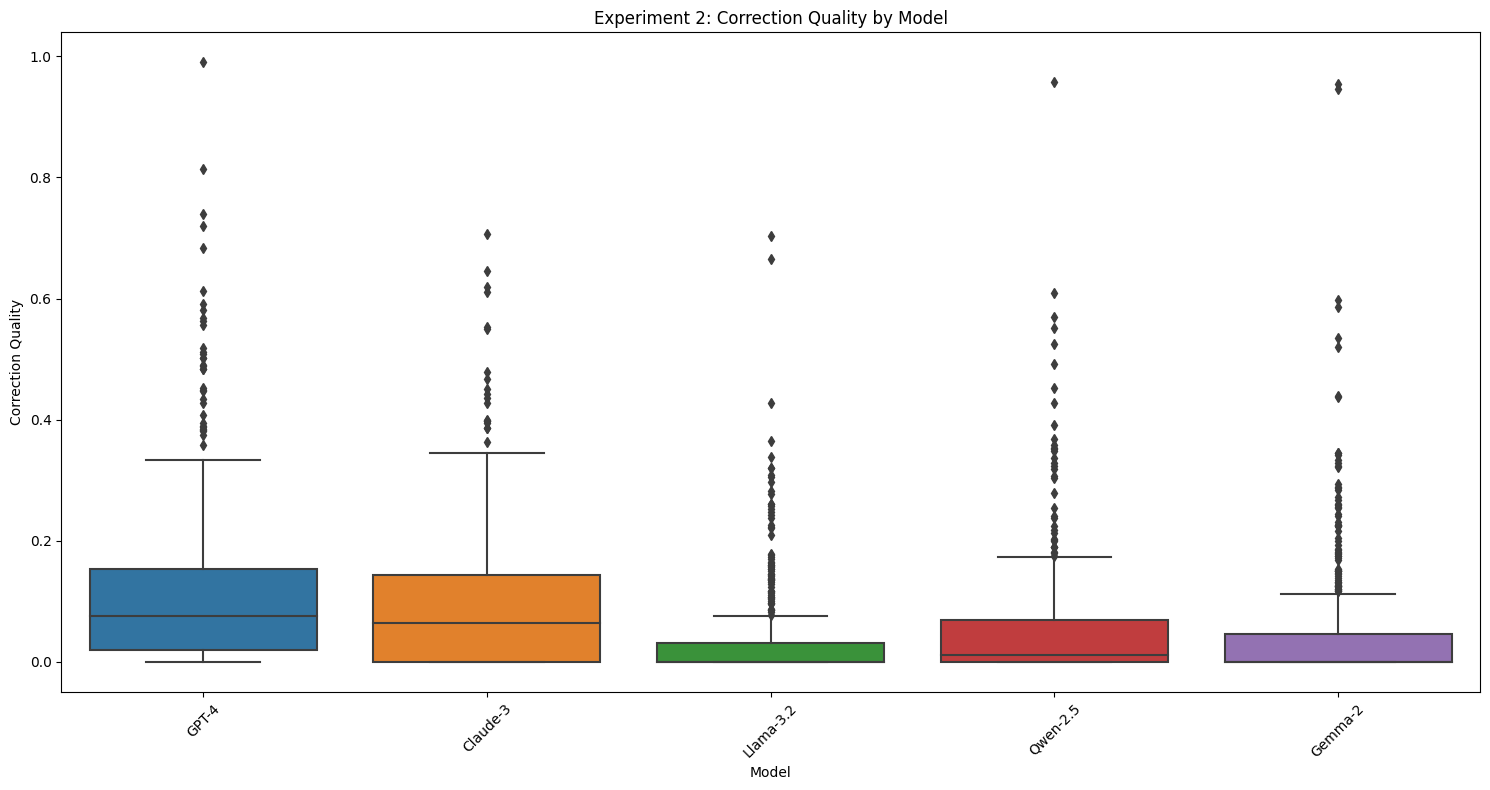

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


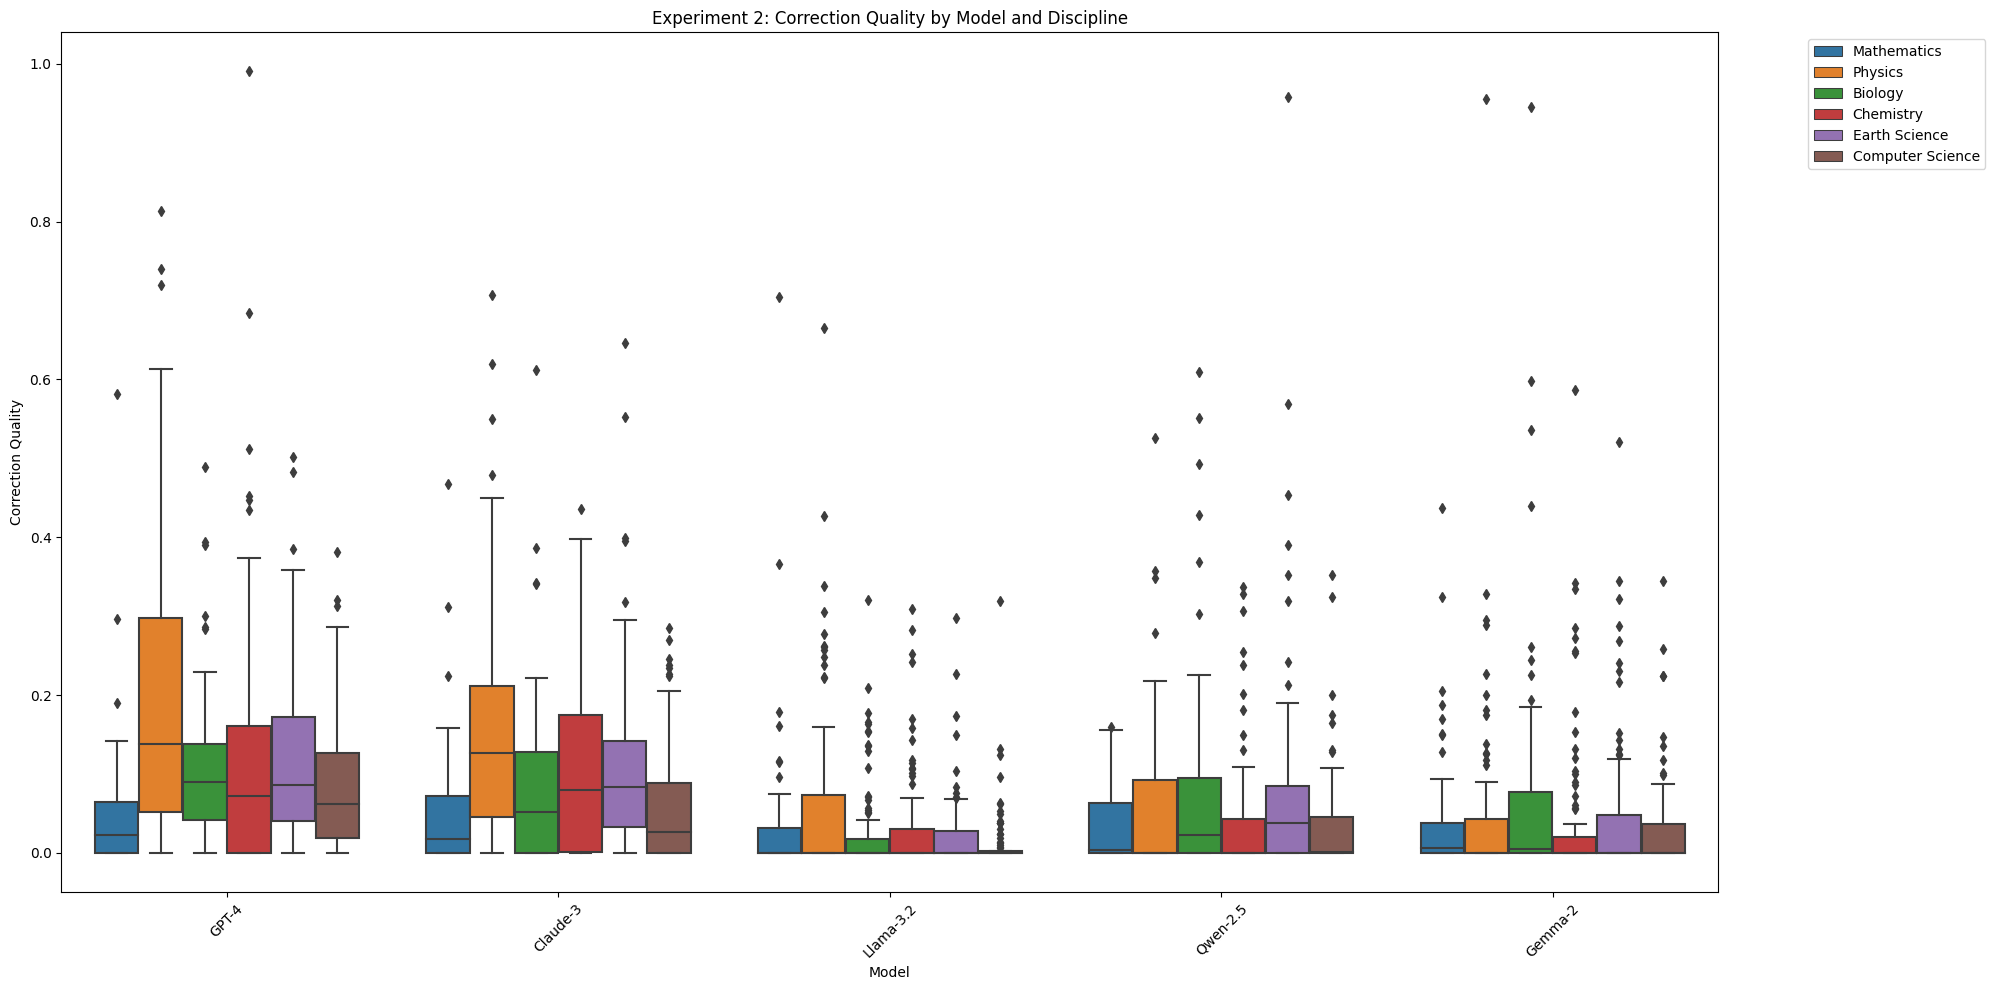

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


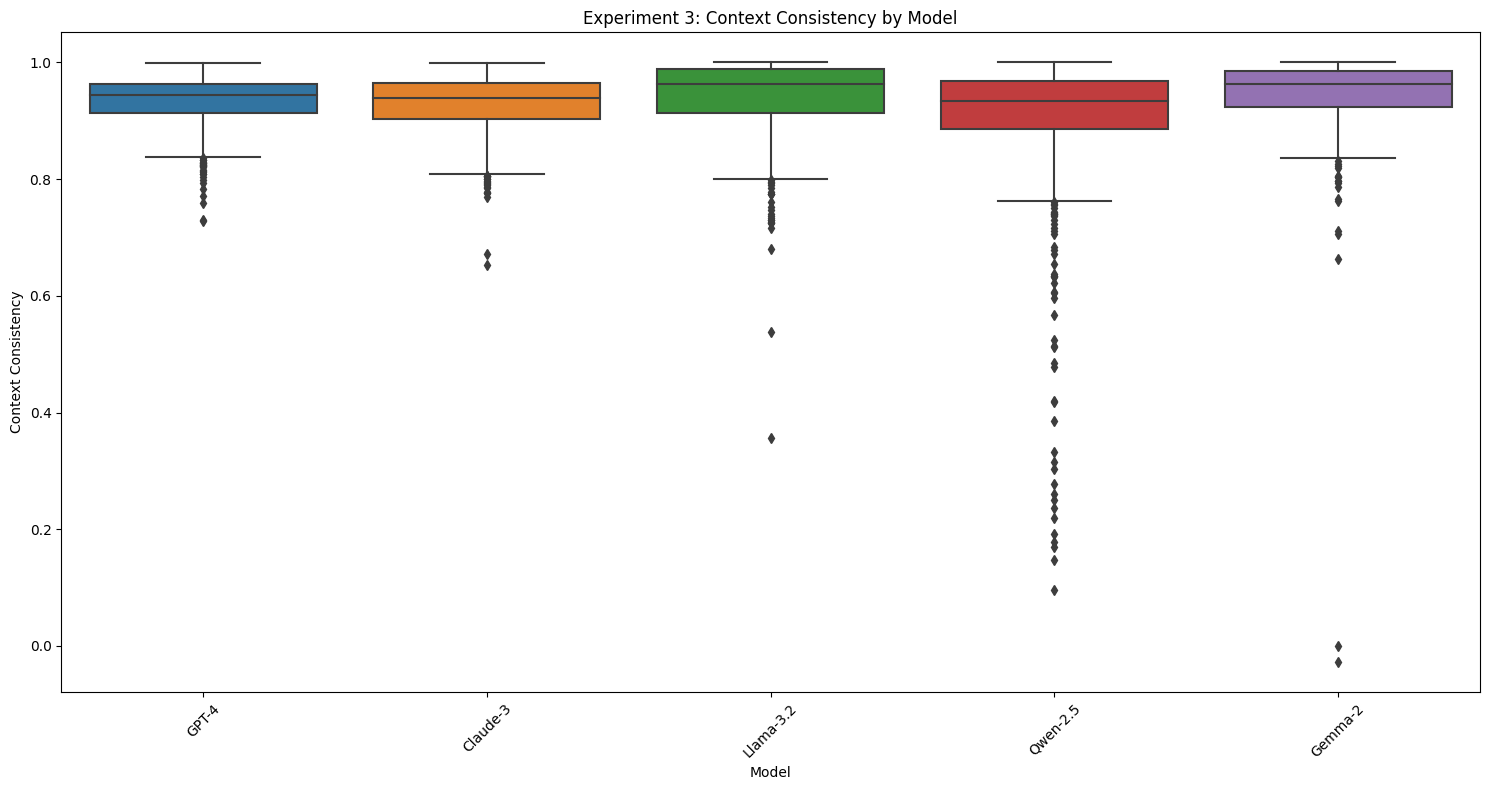

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


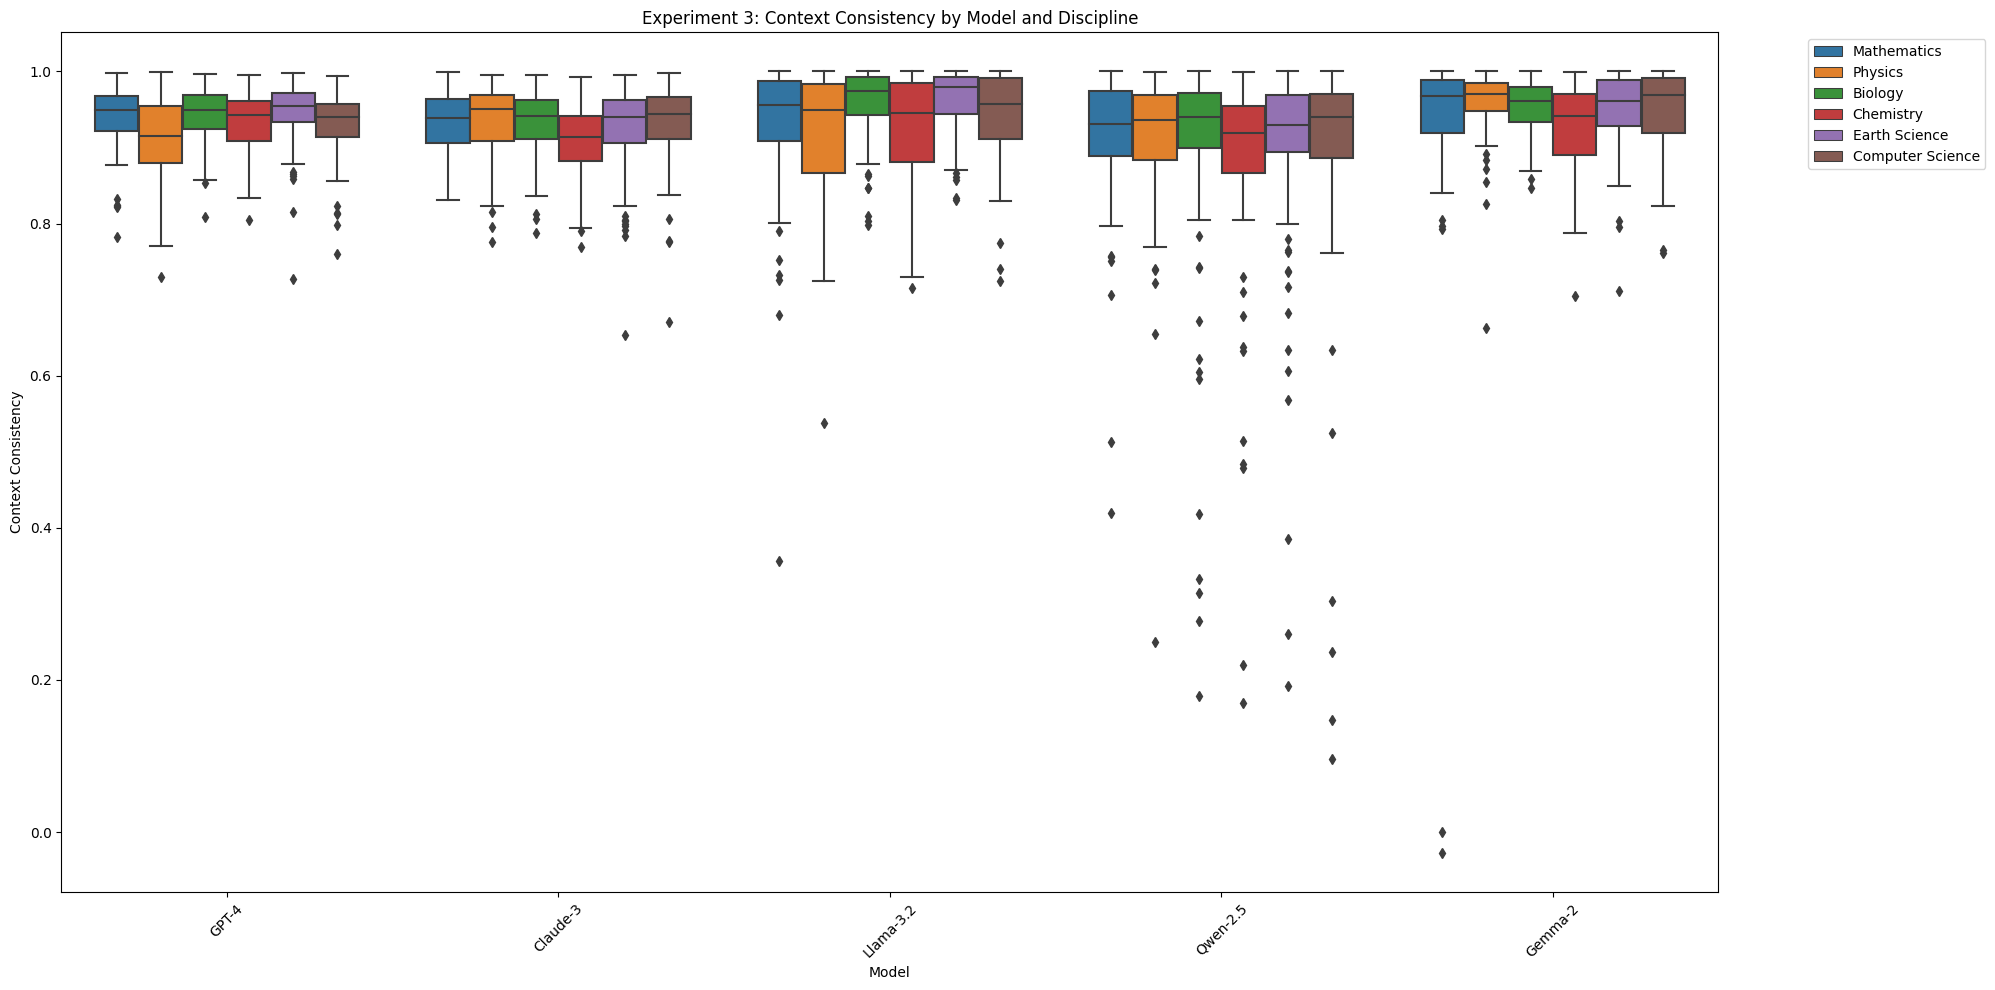

In [22]:
result_files = [
    'results_GPT.csv',
    'results_Claude.csv',
    'results_Llama.csv',
    'results_Qwen.csv',
    'results_Gemma.csv'
]
run_analysis(result_files)